<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [2]:
# Import all necessary libraries.
import sys
import glob
import matplotlib.pyplot as plt
import cv2
import copy

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [3]:
from NomeroffNet.YoloV5Detector import Detector

detector = Detector()
detector.load()

In [4]:
from NomeroffNet.BBoxNpPoints import NpPointsCraft, getCvZoneRGB, convertCvZonesRGBtoBGR, reshapePoints
from NomeroffNet.MultiLineNPExtractor import CCraft
                                            

ccraft = CCraft()
npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/tools/../../data/./models/NpPointsCraft/craft_mlt/craft_mlt_25k_2020-02-16.pth)
Loading weights of refiner from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/tools/../../data/./models/NpPointsCraft/craft_refiner/craft_refiner_CTW1500_2020-02-16.pth)


In [5]:
from NomeroffNet.MultiLineNPExtractor import convert_multiline_to_one_line

In [6]:
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector


optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "latest"
    }
})

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

multiline_images/296023036.jpeg
(640, 480, 3)
[[193.0, 409.0, 277.0, 451.0, 0.9349770545959473, 0.0]]


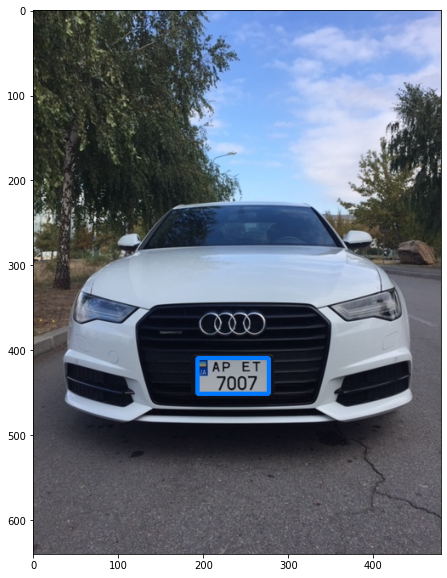

all_points
[[193.0, 409.0, 277.0, 451.0, 0.9349770545959473, 0.0]]
['eu_ua_2015']
[2]


/mnt/data/var/www/nomeroff-net/NomeroffNet/nnmodels/numberplate_options_model.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = functional.softmax(self.fc3_reg(x1))
/mnt/data/var/www/nomeroff-net/NomeroffNet/nnmodels/numberplate_options_model.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x2 = functional.softmax(self.fc3_line(x2))


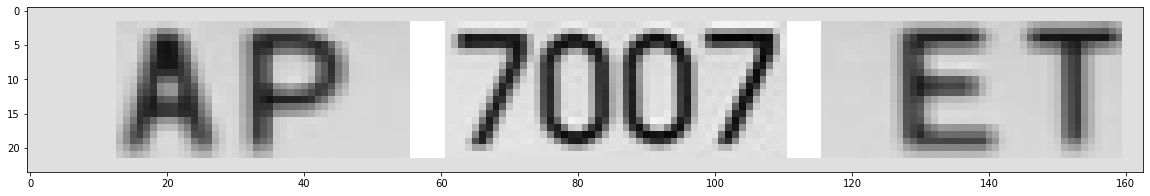

['AP7007ET']
multiline_images/inx960x640.jpg
(1152, 864, 3)
[[285.0, 613.0, 411.0, 708.0, 0.9146479964256287, 0.0]]


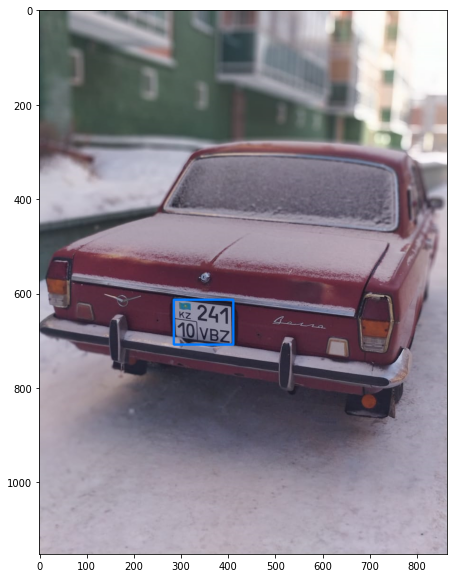

all_points
[[285.0, 613.0, 411.0, 708.0, 0.9146479964256287, 0.0]]
['kz']
[2]


/mnt/data/var/www/nomeroff-net/NomeroffNet/nnmodels/numberplate_options_model.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = functional.softmax(self.fc3_reg(x1))
/mnt/data/var/www/nomeroff-net/NomeroffNet/nnmodels/numberplate_options_model.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x2 = functional.softmax(self.fc3_line(x2))


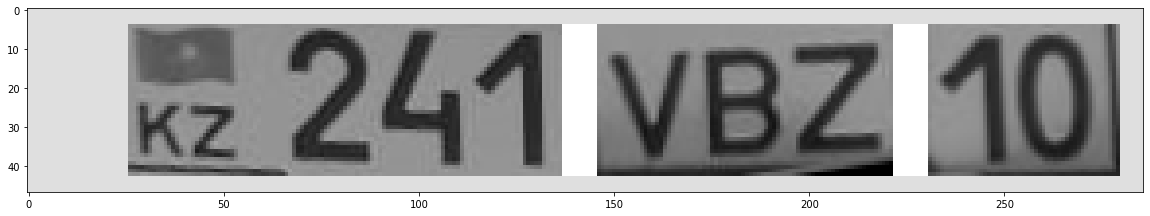

['241VBZ10']


In [8]:
rootDir = 'multiline_images/*'


for img_path in glob.glob(rootDir):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img_path)
    targetBoxes = detector.detect_bbox(copy.deepcopy(img))
    targetBoxes = [[float(item) for item in target_box] for target_box in targetBoxes]
    
    
    print(img.shape)
    print(targetBoxes)
    for targetBox in targetBoxes:
        cv2.rectangle(img, 
                      (int(targetBox[0]), int(targetBox[1])), 
                      (int(targetBox[2]), int(targetBox[3])), 
                      (0,120,255), 
                      3)
    plt.imshow(img)
    plt.show()
    
    all_points, all_mline_boxes = npPointsCraft.detect_mline(img, targetBoxes)
    all_mline_boxes = [[mline_box.tolist() for mline_box in mline_boxes] for mline_boxes in all_mline_boxes]
    
    # for  images/14.jpeg bug
    all_points = [ps for ps in all_points if len(ps)]
    
    print('all_points')
    print(targetBoxes)
    # cut zones
    toShowZones = [getCvZoneRGB(img, reshapePoints(rect,1)) for rect in all_points]
    zones = convertCvZonesRGBtoBGR(toShowZones)    

    # find standart
    regionIds, countLines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    print(regionNames)
    print(countLines)
    
    zones = convert_multiline_to_one_line(img,
                                          zones,
                                          all_mline_boxes,
                                          targetBoxes,
                                          countLines,
                                          regionNames)
    
    for zone in zones:
        plt.imshow(cv2.cvtColor(zone, cv2.COLOR_BGR2RGB))
        plt.show()
                
    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, countLines)
    print(textArr)